# Exposin Project State
The core features are done. Optimizations have been tuned.
## Python Bindings
Classes representing the Lambert BVP for exposins and exposins themselves are exposed:

In [2]:
import PyKEP as pk
 
r1 = [149.0e9, 0.0, 0.0]
r2 = [300.0e9, -100.0e9, 0.0]
mu = 1.32e20
tof = 86400 * 550.0
lw = True
multirevs = -1 # signal automatic revolution detection
k2 = 0.2
 
prob = pk.lambert_exposin(r1, r2, tof, mu, lw, multirevs, k2)
exps = prob.get_exposins()

REPL functionality and some other readout functions are implemented:

In [3]:
print prob
isp = 5000
mass = 4000
print 'Exposin solutions:'
for ex in exps:
    print '-'
    print 'Mass: %.1f kg -> %.1f kg'            % (mass, ex.get_final_mass(mu, isp, mass))
    print 'Maximum thrust needed: %.3f N'       % ex.get_maximum_thrust(mu, isp, mass)
    print 'Revolutions: %i'                     % ex.get_revs()
    print 'Total angle traversed: %.1f degrees' % (ex.get_psi() * pk.RAD2DEG)

Lambert's problem (exponential sinusoid):
mu = 1.32e+20
r1 = [149000000000, 0, 0]
r2 = [300000000000, -100000000000, 0]
angle = 5.961435
time of flight: 4.752e+07
has solutions? 1
maximum number of revolutions: 2
solutions: 3
Rev := 0, v1 := [277.30383820577742, 30456.984023135745, 0], v2 := [10427.031026032262, 17741.430637825742, 0]
Rev := 1, v1 := [-8046.8798851964148, 29199.588573437366, 0], v2 := [12245.450615796277, 16433.05529222621, 0]
Rev := 2, v1 := [-8870.8954820043236, 28386.054401881967, 0], v2 := [11108.45117997797, 16791.845217387807, 0]

Exposin solutions:
-
Mass: 4000.0 kg -> 3358.8 kg
Maximum thrust needed: 0.893 N
Revolutions: 0
Total angle traversed: 341.6 degrees
-
Mass: 4000.0 kg -> 2060.2 kg
Maximum thrust needed: 4.273 N
Revolutions: 1
Total angle traversed: 701.6 degrees
-
Mass: 4000.0 kg -> 796.2 kg
Maximum thrust needed: 16.174 N
Revolutions: 2
Total angle traversed: 1061.6 degrees


And graphing:

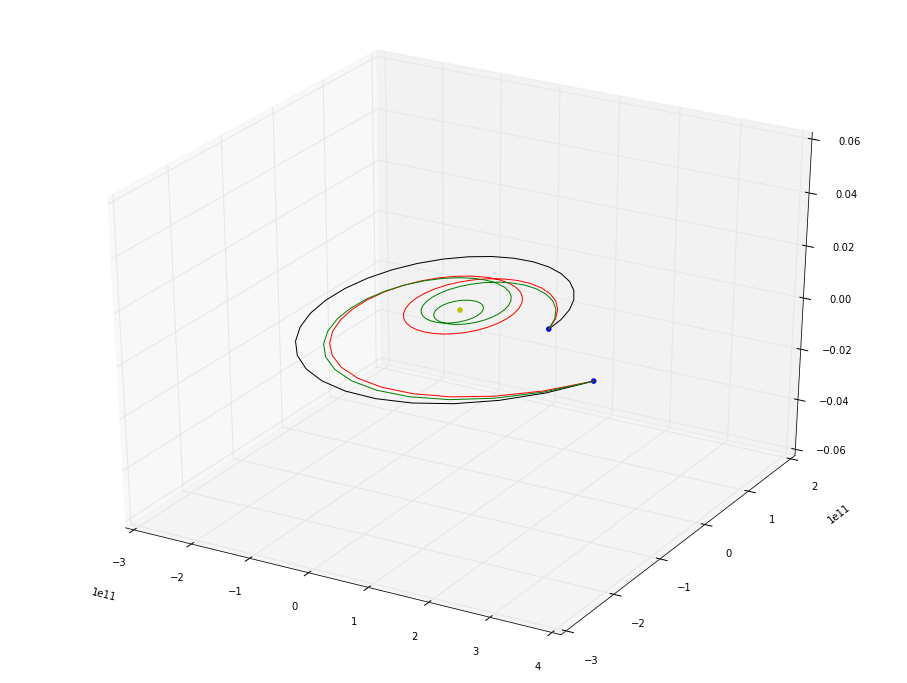

In [4]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 12

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
axis = fig.gca(projection='3d')
 
axis.scatter([0],[0],[0],color='y')
axis.scatter([r1[0]],[r1[1]],[r1[2]],color='b')
axis.scatter([r2[0]],[r2[1]],[r2[2]],color='b')

for i in range(3):
    pk.orbit_plots.plot_lambert_exposin(prob,axis,sol=i,color=['k','r','g','b'][i])
 
plt.show()

Some solutions are clearly not useful!

In all, the Python bindings contain:

`lambert_exposin` object
* get_v1()
* get_v2()
* get_r1()
* get_r2()
* get_tof()
* get_mu()
* get_revs()
* get_exposins()

`exposin` object (no constructor)
* get_psi()
* get_revs()
* get_state()
* get_final_mass()
* get_maximum_thrust()


A graphing utility in `orbit_plots`

## C++ backend
* `lambert_exposin`, `class_exposin`, and `exposin` classes are implemented entirely within header files at the moment.

* `lambert_exposin` provides the solutions to a Lambert BVP.

* `class_exposin` handles the relevant exposin space for `lambert_exposin` and handles TOF searching - I do not think it is useful alone, so I did not create bindings.

* `exposin` represents a single exponential sinusoid trajectory. The C++ `exposin` class has some extra helper functions relating to its geometry that are left public but not exposed in Python (yet - I don't know if they will be needed).

A few tuning parameters are set at the top of each file (mostly tolerances and iteration limits).

## Speed in comparison to conic lambert solver

In [5]:
setup = '''
import PyKEP as pk
r1 = [149.0e9, 0.0, 0.0]
r2 = [300.0e9, -100.0e9, 0.0]
mu = 1.32e20
tof = 86400 * 550.0
lw = True
N = 0
k2 = 0.2
'''
import timeit
t_exp = timeit.repeat("pk.lambert_exposin(r1,r2,tof,mu,lw,N,k2)", setup, number=5000)
t_lam = timeit.repeat("pk.lambert_problem(r1,r2,tof,mu,lw,N)", setup, number=5000)

print 'Time ratio: %.2fx' % (max(t_exp)/min(t_lam))

Time ratio: 3.73x


### Earth-Apophis Transfer

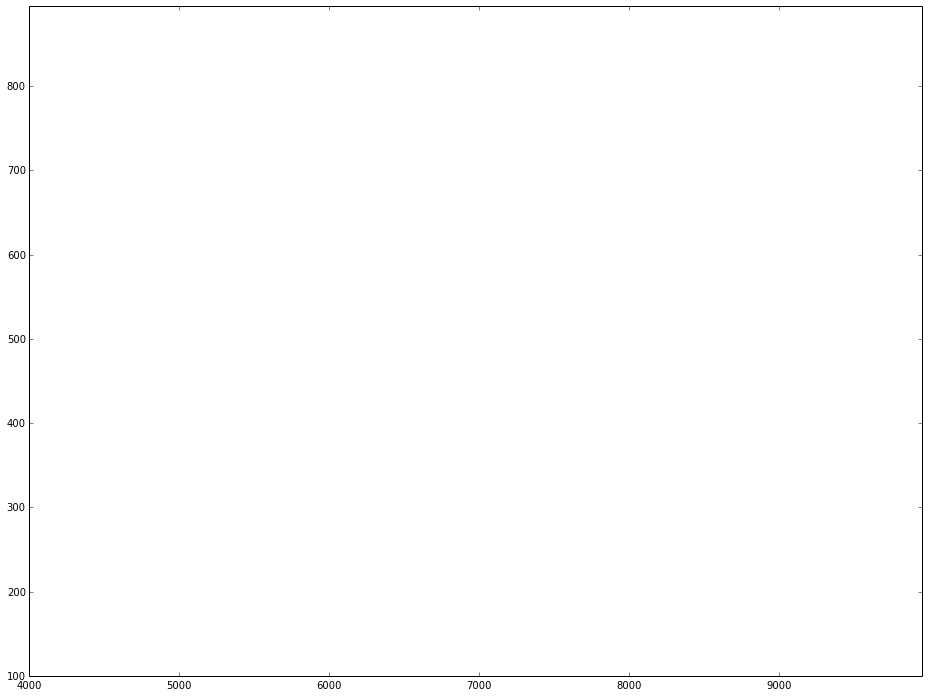

In [5]:
import math
import numpy
import PyKEP as pk
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 12

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

earth = pk.planet.jpl_lp('earth')
apophis = pk.planet.jpl_lp('mars')
#apophis = pk.planet.mpcorb('99942   19.2   0.15 K107N 202.49545  126.41859  204.43202    3.33173  0.1911104  1.11267324   0.9223398  1 MPO164109  1397   2 2004-2008 0.40 M-v 3Eh MPCAPO     C802  (99942) Apophis            20080109')
g0 = 9.81
isp = 5000
k2 = 0.6
n = 0

def J(dv0, lt_massratio):
    initial_mass = 1.0
    initial_mass *= math.exp(-dv0/g0/isp)
    initial_mass *= lt_massratio
    return initial_mass

@numpy.vectorize
def binJ(t0, tof):
    ep = pk.epoch(t0 + tof, "mjd")
    r1, v1 = earth.eph(ep)
    r2, v2 = apophis.eph(ep)
    prob = pk.lambert_exposin(r1, r2, tof*pk.DAY2SEC, pk.MU_SUN, False, n, k2)
    revs = prob.get_revs()
    if revs > -1:
        exps = prob.get_exposins()[0]
        vf = prob.get_v1()[0]
        dv2 = [(vfi - v1i)**2 for vfi, v1i in zip(vf, v1)]
        dv = math.sqrt(sum(dv2))
        massratio = exps.get_final_mass(pk.MU_SUN, isp, 1.0)
        j = J(dv, massratio)
        return j
    return 0.0

t0 = numpy.arange(4000, 10000, 50)
tof = numpy.arange(100, 900, 5)
X,Y = numpy.meshgrid(t0, tof)
Z = binJ(X,Y)
plt.figure()
plt.contour(X,Y,Z)
plt.show()